#### Overview

Empty Bloom filters are arrays of $m$ bits, starting with an array of $m$ 0's. For a given bloom filter, there are $k$ hash functions defined. Each of these functions hashes an element to a position to get k array positions. Usually, $k$ is a constant, much smaller than the number of bits $m$, proportional to the number of elements to be added to the bloom filter. Depending on the intended false positive rate of the bloom filter, the size of $k$ is chosen.

The operations that bloom filters support are INSERT element or ADD element, and QUERY element.

ADD element `x` consists of modifying the bits of the filter, if needed, so that all the poisitions given by the $k$ hash values of the element for each of the hash functions, is equal to 1. In other words, for each of the hash values $h_i(x)$, the bit in the position $h_i(x)$ is set to 1.

QUERY for an element `x` consists of checking each of the bits in the positions given by the $k$ hash values. If any of these bits is equal to 0, it means that `x` was never added - otherwise, as the ADD operation specifies, all the bits in those positions should be 1. If all the bits in these positions are equal to 1, then the `x` is possibly in set - it could be that by setting values equal to 1 when adding other elements, all the bits in positions given by the hash values of `x` where set to 1 without adding `x`. For this reason, the QUERY function tells use either an element is NOT in the set or an element MAY be in the set.

The following code implements a bloom filter as a list:

In [6]:
import math
import mmh3

m = 10
n = 50
k = int((m/n)*math.log(2))

#initializing bloom filter with bits equal to 0
bloomfilter = [0 for i in range(m)]

def add(Bf, x, k):
    for i in range(k):
        Bf[mmh3.hash(x,i)] = 1

def query(Bf, x, k):
    for i in range(k):
        if Bf[mmh3.hash(x,i)] == 0:
            return False
    return True


print(bloomfilter)

ImportError: No module named mmh3

The hash functions implemented in my bloom filter are from the well-known MurmurHash library. The functions that these library staisfy the property of independence and uniformity. The algorithm performs a series of arithmetic and XOR's operations to hash the values. The algorithm can be found $\href{https://en.wikipedia.org/wiki/MurmurHash}{here}$.

The following data visualizations illustrate the uniformity of the hash functions by the MurmurHash library, and graphically demonstrate that we can assume independence and uniformity in our bloom filter.

In [ ]:
distribution = [0,0,0,0,0,0,0,0,0,0]
for i in range(10000):
    distribution[mmh3.hash('451',i)%10]=distribution[mmh3.hash('451',i)%10]+1

print(distribution)

Let's say that $m$ is the size of the array, $n$ is the number of elements that will be inserted, and $k$ is the number of hash functions. We can also assume that the hash functions are independent and uniformly distributed as those are properties of the mmh3 hash functions.

The probability that a bit is set to 1 by one of our hash functions is $\frac{1}{m}$ as the function will only set to 1 only one of the $m$ bits and with the same probability. Thus, the probability that a certain bit is not set to 1 is $1-\frac{1}{m}$. 
This number is just for one of the functions so the probability that a bit is not set to 1 by any of the $k$ functions is $(1-\frac{1}{m})^k$, because the functions are independent from each other.

Now, we calculated the probability for a bit not to be set to 1 after the insertion of one element ($k$ hash functions per element). If we want the probability for a bit not to be set to 1 after the insertion of $n$ elements, we need to multiply $(1-\frac{1}{m})^k$ by itself $n$ times (once per element). Thus, we get $(1-\frac{1}{m})^{kn}$

Given this last probability, we can calculate the probability of a false positive. For a false positive to happen, then each of the bits resulting from the hashing the element we are querying for have to be set to 1 after the insertion of the $n$ elements. For each of these bits, we saw that the probability of them not being $1$ is $(1-\frac{1}{m})^{kn}$, thus the probability of the bit to be $0$ is $1-(1-\frac{1}{m})^{kn}$. Then, we need ALL bits to be 1 for a false positive to happen, so the probability of all of the $k$ being 1, is $(1-(1-\frac{1}{m})^{kn})^k \approx (1-e^{\frac{-kn}{m}})^k$.

Now that we know the probability of false positive rate $p$, we can calculate the number of $k$ hash functions that minimizes $p$ given $m$ and $n$. This value is given by the following formula

\begin{align*}
k = \frac{m}{n}\ln{2} \\
\end{align*}

Now, if we assume that we will use the value of $k$ that minimizes the false positive rate, we can substitute the $k$ value from the formula above in our probability of false positive. After doing this and some $\href{https://en.wikipedia.org/wiki/Bloom_filter}{algebra}$, we get the following formula

\begin{align*}
m = \frac{-n\ln{p}}{(\ln2)^2}
\end{align*}

Using these last formula we can calculate how the implementation of the bloom filter scales in terms of the following:

$\\$

###### i. memory size as a function of the false positive rate

Because the probability $p$ is a number on the interval $[0,1]$, we know that $\ln{p}$ negative and thus $-\ln{p}$ is positive. As $p$ increases, $\ln{p}$ increases, but because it is negative on the domain of $p$ then the absolute value of $\ln{p}$ decreases, which means that $-\ln{p}$ decreases as $p$ increases. This means that the memory size $m$ decreases logarithmically as the false positive rate $p$ increases, and vice versa.

$$\\$$

###### ii. memory size as a function of the number of items stored

Knowing that $-\ln{p} > 0$, from the formula we can see that as $n$ increases, so does $\frac{-n\ln{p}}{(\ln2)^2}$, and because the term $n$ is simply a factor of the formula, then the memory size $m$ increases linearly as the number of items stored $n$ increases, and decreases linearly as $n$ decreases.

$$\\$$

###### iii. access time as a function of the false positive rate

The access time is dependent on the number of hash functions $k$ as insertion and query take $O(k)$ time. For this reason we need to know how $k$ scales as a function of the false positive rate. From the formula we got for $k$ that minimizes false positive rate $k = \frac{m}{n}\ln{2}$, we can substitute the value of $m$ using $m = \frac{-n\ln{p}}{(\ln2)^2}$. After simplyfing the function that we get is:

\begin{align*}
k = \frac{-ln{p}}{ln2} = -\log_{2}{p}
\end{align*}

Which means that access time decreases logarithmically as $p$ increases (again, we use the fact that the absolute value of $-\log_{2}{p}$ decreases as $p$ increases, and thus $-\log_{2}{p}$ decreases as $p$ increases), and it increases logarithmically as $p$ decreases.

$$\\$$

###### iv. access time as a function of the number of items stored

For this case, we need to know how $k$ scales as a function of $n$. Using the formula $k = \frac{m}{n}\ln{2}$, we can see that $k$ is inversely proportional to $n$, which means that as $n$ increases, access time decreases inversely proportional.

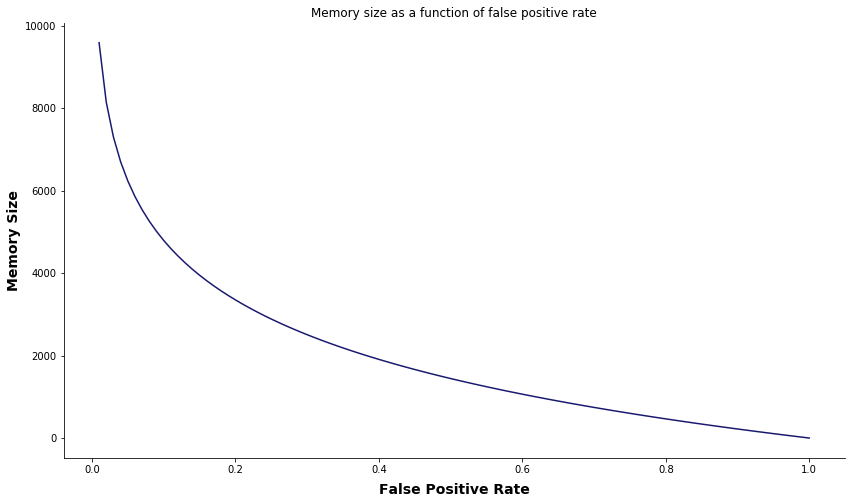

In [4]:
import matplotlib.pyplot as plt
import numpy as nmp
import math

#memory size as a function of false positive rate
#m as a function of p

plt.figure(figsize=(14, 8))  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

#fixed n
n = 1000
P = [0.01*i for i in range(1,101)]
M_function_of_p = [float(-n*math.log(p))/float((math.log(2))**2) for p in P]

plt.plot(P,M_function_of_p, color ='#191970')
plt.legend(prop={'size':12})
plt.xlabel('False Positive Rate',fontsize=14,weight='bold',labelpad=8)
plt.ylabel('Memory Size',fontsize=14,weight='bold')
plt.title('Memory size as a function of false positive rate')

plt.show()